<table>
  <tr>
      <td><div style="white-space: pre-wrap;" align="left"><font size="30" >Tutorial B2&#10;SLAM </font></div></td>
     <td><img src="https://github.com/Tobias-Fischer/RVSS2022/blob/main/Spatial_Awareness/Tutorial_B2_Robot_Localisation/image/RVSS-logo.png?raw=1" width="400"></td>
  </tr>
</table>

# Load data and run SLAM

In [22]:
import os
import math
import numpy as np
import pickle
from importlib import import_module

!git clone https://github.com/Tobias-Fischer/RVSS2022.git
os.chdir('RVSS2022/Spatial_Awareness/Tutorial_B2_Robot_Localisation')

#Visualizer
from Render import *
#Here we import Robot class definition form the other notebook
from EKF_Robot import *
#Here we import a class that defines out measurments
from Measurements import *
#This implements the EKF
import EKF

from SLAM_Robot import *
#Here is SLAM
import Slam

#Here we load our data including the true state 
with open('data/data_slam.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state']
control = data['control']
measurements = data['measurement']


Cloning into 'RVSS2022'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (527/527), done.
remote: Compressing objects: 100% (420/420), done.
remote: Total 527 (delta 276), reused 304 (delta 99), pack-reused 0
Receiving objects: 100% (527/527), 35.61 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (276/276), done.



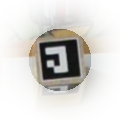
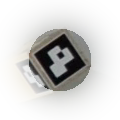
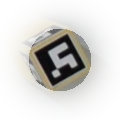
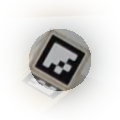
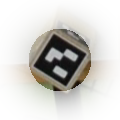
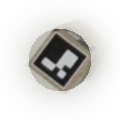
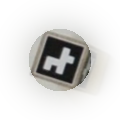
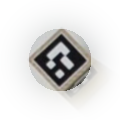
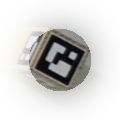
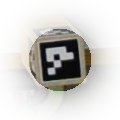

In [23]:
#Now lets see how well slam does
#Create a robot and place it at the true starting position and orientation 
bot = SLAM_Robot(0.14, 0.01)
#Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.state = gt_state[0,:].copy().reshape(-1,1)

slammer = Slam.Slam(bot)

#----------------------------------------PARAMETERS----------------------------------
#
#Initial incertainty of our robot
slammer.P = np.eye(3)*0.001
#Uncertainty in our left and right wheel motors
sigma_drive = np.array([0.1,0.1])
#Uncertainty in measurement ~10cm
sigma_measure = np.eye(2)*0.1
#
#-------------------------------------------------------------------------------------

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))
#Here we will save all of the landmarks added to our map
landmarks = []
#Here we save the robot covariances
robot_cov = np.zeros(((control.shape[0],3,3)))
#Here we save the marker covariances
marker_cov = []
for c in range(control.shape[0]):
    #Set the measurement covariances
    for mes in measurements[c]:
        mes.covariance = sigma_measure 
    
    slammer.add_landmarks(measurements[c])
    # Drive and predict
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    slammer.predict(drive_signal)
    slammer.update(measurements[c])
    
    marker_cov.append(slammer.P[3:,3:])
    state[c,:] = bot.state[:,0]
    landmarks.append(slammer.markers)
    robot_cov[c,:,:] = slammer.P[0:3,0:3]
    
#Create a visualizer and visualize our atate
#rend = Rendered.Instance()
#rend.initialize(state,measurements,gt_state = gt_state,landmarks=landmarks,robot_cov=robot_cov,marker_cov=marker_cov)
Render(state=state, gt_state=gt_state, measurements=measurements, robot_cov=robot_cov, landmarks=landmarks, marker_cov=marker_cov)